## Download the data

We first need to load the data from the ProPublica repo:
https://github.com/propublica/compas-analysis


# Course Project

## Dataset

You will examine the ProPublica COMPAS dataset, which consists of all criminal defendants who were subject to COMPAS screening in Broward County, Florida, during 2013 and 2014. For each defendant, various information fields (‘features’) were also gathered by ProPublica. Broadly, these fields are related to the defendant’s demographic information (e.g., gender and race), criminal history (e.g., the number of prior offenses) and administrative information about the case (e.g., the case number, arrest date, risk of recidivism predicted by the COMPAS tool). Finally, the dataset also contains information about whether the defendant did actually recidivate or not.

The COMPAS score uses answers to 137 questions to assign a risk score to defendants -- essentially a probability of re-arrest. The actual output is two-fold: a risk rating of 1-10 and a "low", "medium", or "high" risk label.

Link to dataset: https://github.com/propublica/compas-analysis

The file we will analyze is: compas-scores-two-years.csv

Link to the ProPublica article:

https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing


## Project goal

The project has three parts: 

- The COMPAS scores have been shown to have biases against certain racial groups. Analyze the dataset to highlight these biases.  

- Based on the features in the COMPAS dataset, train classifiers to predict who will re-offend (hint: no need to use all features, just the ones you find relevant).  Study if your classifiers are more or less fair than the COMPAS classifier. 

- Build a fair classifier (last lecture will cover fair classification techniques). Is excluding the race from the feature set enough?


## Today

Explore the dataset and do some initial statistics. 

In [1]:
import urllib
import os, sys, torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
import torch.utils.data as dt 

from pylab import rcParams

from sklearn import feature_extraction
from sklearn import preprocessing
from random import seed, shuffle
from datetime import datetime
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier

## Load data and clean it up
We followed the method ProPublica used in their analyse. 

In [2]:
SEED = 1234
seed(SEED)
np.random.seed(SEED)

def check_data_file(fname):
    files = os.listdir(".") # get the current directory listing
    print("Looking for file '%s' in the current directory...",fname)

    if fname not in files:
        print("'%s' not found! Downloading from GitHub...",fname)
        addr = "https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv"
        response = urllib.request.urlopen(addr)
        data = response.read()
        fileOut = open(fname, "wb")
        fileOut.write(data)
        fileOut.close()
        print("'%s' download and saved locally..",fname)
    else:
        print("File found in current directory..")

    
COMPAS_INPUT_FILE = "compas-scores-two-years.csv"
check_data_file(COMPAS_INPUT_FILE)

df = pd.read_csv(COMPAS_INPUT_FILE)   #df is a dataframe


df = df.dropna(subset=["days_b_screening_arrest"]) # dropping missing vals (NaN for sure, also null???)

df = df[
    (df.days_b_screening_arrest <= 30) &  
    (df.days_b_screening_arrest >= -30) &  
    (df.is_recid != -1) &
    (df.c_charge_degree != 'O') &
    (df.score_text != 'N/A')
]    # Only keep the values that forfull these constraints

df.reset_index(inplace=True, drop=True) # renumber the rows from 0 again

df_backup=df

Looking for file '%s' in the current directory... compas-scores-two-years.csv
File found in current directory..


In [3]:
print("shape: " + str(df.shape))   # Tuple representing the dimensionality
print("index (the amount of convict = 7214) : " + str(df.index))   # The index (row labels) of the DataFrame.
print("Different features of the convicts (53): " + str(df.columns))
print("Different features of the convicts (53): " + str(df.keys())) # we can also use keys()
print("index.value_counts (???): " + str(df['race'].value_counts())) # count the unique values in a column
print("Display the first 3 rowns:" + str(df.head(5)))

table = pd.read_csv('compas-scores-two-years.csv',delimiter = ',')
print(table.isnull())#is null checks missing values in a table, return a table of boolean




shape: (6172, 53)
index (the amount of convict = 7214) : RangeIndex(start=0, stop=6172, step=1)
Different features of the convicts (53): Index(['id', 'name', 'first', 'last', 'compas_screening_date', 'sex', 'dob',
       'age', 'age_cat', 'race', 'juv_fel_count', 'decile_score',
       'juv_misd_count', 'juv_other_count', 'priors_count',
       'days_b_screening_arrest', 'c_jail_in', 'c_jail_out', 'c_case_number',
       'c_offense_date', 'c_arrest_date', 'c_days_from_compas',
       'c_charge_degree', 'c_charge_desc', 'is_recid', 'r_case_number',
       'r_charge_degree', 'r_days_from_arrest', 'r_offense_date',
       'r_charge_desc', 'r_jail_in', 'r_jail_out', 'violent_recid',
       'is_violent_recid', 'vr_case_number', 'vr_charge_degree',
       'vr_offense_date', 'vr_charge_desc', 'type_of_assessment',
       'decile_score.1', 'score_text', 'screening_date',
       'v_type_of_assessment', 'v_decile_score', 'v_score_text',
       'v_screening_date', 'in_custody', 'out_custody', 'pr

## Basic analysis of demographics

- Different races present in the dataset:

In [4]:
print(df.race.drop_duplicates().values)

['Other' 'African-American' 'Caucasian' 'Hispanic' 'Asian'
 'Native American']


- Number of people by age category:

In [5]:
print("number of people by age category: \n" + str(df['age_cat'].value_counts())) # count the unique values in a column

number of people by age category: 
25 - 45            3532
Less than 25       1347
Greater than 45    1293
Name: age_cat, dtype: int64


- Number of people by race:

In [6]:
print("number of people by race: \n" + str(df['race'].value_counts())) # count the unique values in a column

number of people by race: 
African-American    3175
Caucasian           2103
Hispanic             509
Other                343
Asian                 31
Native American       11
Name: race, dtype: int64


- Number of people by COMPAS score:

In [7]:
print("number of people by COMPAS score: \n" + str(df['decile_score'].value_counts())) # count the unique values in a column

number of people by COMPAS score: 
1     1286
2      822
4      666
3      647
5      582
6      529
7      496
9      420
8      420
10     304
Name: decile_score, dtype: int64


- Number of people by COMPAS risk category:

In [8]:
print("number of people by COMPAS risk category: \n" + str(df['score_text'].value_counts())) # count the unique values in a column

number of people by COMPAS risk category: 
Low       3421
Medium    1607
High      1144
Name: score_text, dtype: int64


We can see from the basic analyse above, the dataset is imbalances in terms of age and races

## Basic investigations of gender and race bias in COMPAS scores

- Mean COMPAS score (decile_score) per race and gender:

In [9]:
tab = df[['decile_score','race','sex']]
stat = tab.groupby(['race', 'sex'])  


for key, item in stat:
    print(key, "\n")
    print(stat.get_group(key).mean(), "\n\n")
    print("number per group:",stat.get_group(key).count()['decile_score'], "\n\n")

('African-American', 'Female') 

decile_score    4.639344
dtype: float64 


number per group: 549 


('African-American', 'Male') 

decile_score    5.410129
dtype: float64 


number per group: 2626 


('Asian', 'Female') 

decile_score    2.0
dtype: float64 


number per group: 2 


('Asian', 'Male') 

decile_score    2.896552
dtype: float64 


number per group: 29 


('Caucasian', 'Female') 

decile_score    3.792531
dtype: float64 


number per group: 482 


('Caucasian', 'Male') 

decile_score    3.588526
dtype: float64 


number per group: 1621 


('Hispanic', 'Female') 

decile_score    2.682927
dtype: float64 


number per group: 82 


('Hispanic', 'Male') 

decile_score    3.517564
dtype: float64 


number per group: 427 


('Native American', 'Female') 

decile_score    8.5
dtype: float64 


number per group: 2 


('Native American', 'Male') 

decile_score    6.0
dtype: float64 


number per group: 9 


('Other', 'Female') 

decile_score    2.741379
dtype: float64 


number per

We can observe here a clear avrage score diffrence in race and gender.

- Distribution (histogram) of decile_score per race and gender:

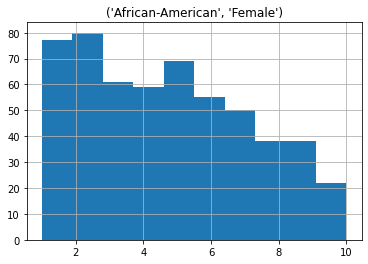

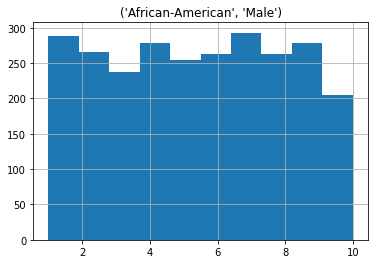

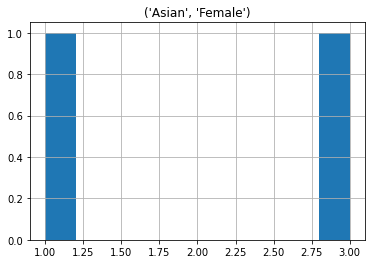

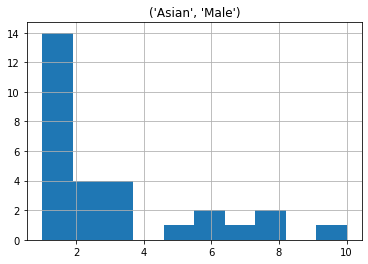

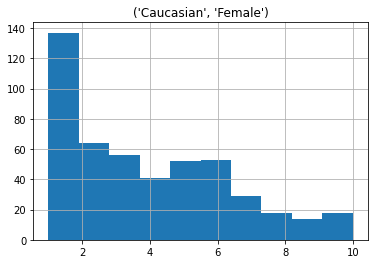

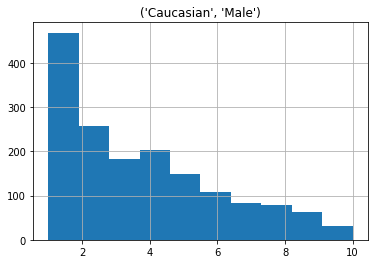

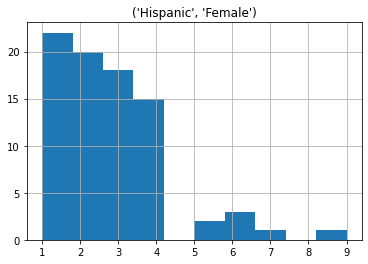

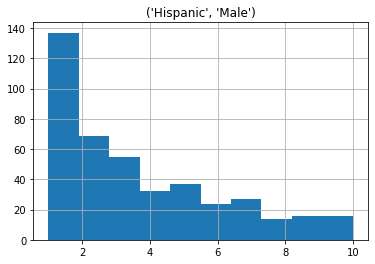

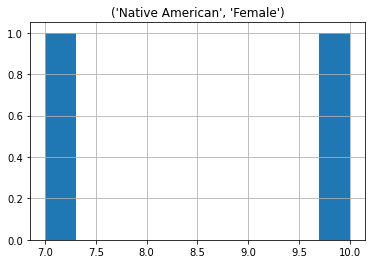

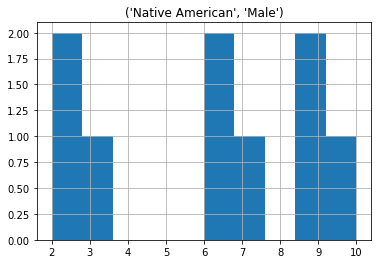

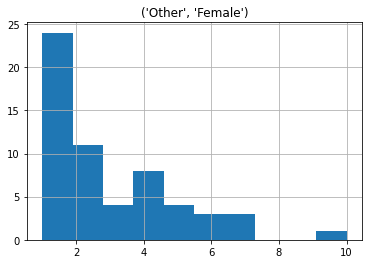

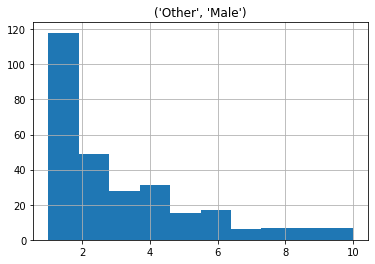

In [10]:
labels=list(stat.groups.keys())


for key, item in stat:
    stat.get_group(key).hist(bins=10)
    plt.title(key)



#stat['decile_score'].hist(bins=10, label=labels)


We can see there that in pretty much all groupes we have a large portion of people were assigned a low score and only a few had been assigned a high score excapet in the group *'African-American', 'Male'*. In this group we have a near equal distribution of scores.

- Number of people were re-arrested: 

In [11]:
df_rearrest = df[df.two_year_recid==1]
df_rearrest = df_rearrest[['decile_score','race','sex']]
print("number of people were re-arrested:",df_rearrest['decile_score'].shape[0])

number of people were re-arrested: 2809


- Recidivism (i.e., people that got re-arrested) rates by race and gender

In [12]:
df_rearrest_bycat = df_rearrest.groupby(['race', 'sex'])  

for key, item in stat:
    print(key, "\n")
    #print(df_rearrest_bycat.get_group(key).mean(), "\n\n")
    print("number per group:",df_rearrest_bycat.get_group(key).count()['race'],"\n")
    print("recidivism rate:",df_rearrest_bycat.get_group(key).count()['race']/stat.get_group(key).count()['race'], "\n\n")

('African-American', 'Female') 

number per group: 203 

recidivism rate: 0.3697632058287796 


('African-American', 'Male') 

number per group: 1458 

recidivism rate: 0.5552170601675552 


('Asian', 'Female') 

number per group: 1 

recidivism rate: 0.5 


('Asian', 'Male') 

number per group: 7 

recidivism rate: 0.2413793103448276 


('Caucasian', 'Female') 

number per group: 170 

recidivism rate: 0.35269709543568467 


('Caucasian', 'Male') 

number per group: 652 

recidivism rate: 0.4022208513263418 


('Hispanic', 'Female') 

number per group: 26 

recidivism rate: 0.3170731707317073 


('Hispanic', 'Male') 

number per group: 163 

recidivism rate: 0.38173302107728335 


('Native American', 'Female') 

number per group: 2 

recidivism rate: 1.0 


('Native American', 'Male') 

number per group: 3 

recidivism rate: 0.3333333333333333 


('Other', 'Female') 

number per group: 11 

recidivism rate: 0.1896551724137931 


('Other', 'Male') 

number per group: 113 

recidivism r

We can see the recidivism rates are not balanced among races and genders 

We calculated the accuracy using the same way *ProPulica* used. That is, if a person is categorised as *Medium* or *High* as score category, it's counted as a positive prediction. A person in *Low* category is a negative prediction.

In [13]:
tab = df[['score_text','race','sex','two_year_recid']]
stat = tab.groupby(['race', 'sex'])  

In [14]:
accurecy = tab[(((df.score_text=='High') | (df.score_text=='Medium')) & (df.two_year_recid==1)) | ((df.score_text=='Low') & (df.two_year_recid==0))].count()['score_text']/tab.count()['score_text']
print("global accurecy", accurecy)

global accurecy 0.6607258587167855


We can see here the accurecy is not high at all.

- Is the accuracy higher/lower if we look at particular races/genders?

('African-American', 'Female') 
 0.6484517304189436 


('African-American', 'Male') 
 0.6492764661081493 


('Asian', 'Female') 
 0.5 


('Asian', 'Male') 
 0.8620689655172413 


('Caucasian', 'Female') 
 0.6556016597510373 


('Caucasian', 'Male') 
 0.6767427513880321 


('Hispanic', 'Female') 
 0.6951219512195121 


('Hispanic', 'Male') 
 0.6557377049180327 


('Native American', 'Female') 
 1.0 


('Native American', 'Male') 
 0.6666666666666666 


('Other', 'Female') 
 0.7931034482758621 


('Other', 'Male') 
 0.656140350877193 




/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Text(0.5, 1.0, 'Accurecy per group by COMPAS')

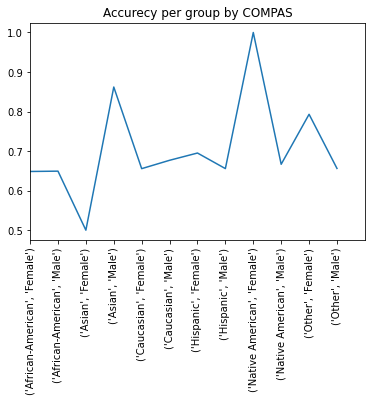

In [15]:
keys=[]
acc_list_compas=[]
for key, item in stat:
    keys.append(key)
    stat_group=stat.get_group(key)
    TPredic=stat_group[(((df.score_text=='High') | (df.score_text=='Medium')) & (stat_group.two_year_recid==1)) | ((stat_group.score_text=='Low') & (stat_group.two_year_recid==0))].count()['score_text']
    Predic=stat_group.count()['score_text']
    if TPredic==0 :
        accurecy = 0
    else:
        accurecy=TPredic/Predic
    print(key,'\n',accurecy, '\n\n')
    acc_list_compas.append(accurecy)

plt.plot(acc_list_compas)
plt.xlim(0,12)
plt.xticks(range(0, 12),keys,rotation=90)
plt.title("Accurecy per group by COMPAS")

As we can see in the graph, the accuracy is not homogeneous among races and genders. The model has a poorer performance for the race *African-American* than *Caucasian*.

- What about false positives and false negatives?

('African-American', 'Female') 
 0.48161764705882354 


('African-American', 'Male') 
 0.32755298651252407 


('Asian', 'Female') 
 0 


('Asian', 'Male') 
 0.2857142857142857 


('Caucasian', 'Female') 
 0.4891304347826087 


('Caucasian', 'Male') 
 0.375 


('Hispanic', 'Female') 
 0.42857142857142855 


('Hispanic', 'Male') 
 0.44029850746268656 


('Native American', 'Female') 
 0 


('Native American', 'Male') 
 0.5 


('Other', 'Female') 
 0.5454545454545454 


('Other', 'Male') 
 0.3728813559322034 




/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


Text(0.5, 1.0, 'False Positive rate per group by COMPAS')

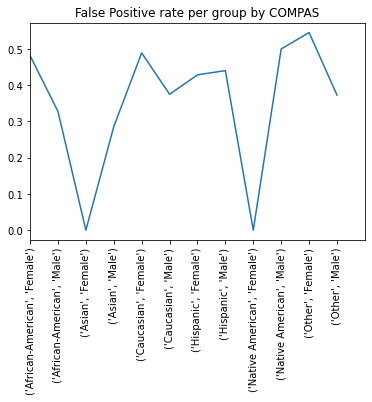

In [16]:
FP_list_compas=[]

def make_FP_list(FP_list,stat):
    for key, item in stat:
        stat_group=stat.get_group(key)
        FPos=stat_group[(((df.score_text=='High') | (df.score_text=='Medium')) & (stat_group.two_year_recid==0))].count()['score_text']
        Pos=stat_group[((df.score_text=='High') | (df.score_text=='Medium'))].count()['score_text']
        if FPos==0 :
            accurecy = 0
        else:
            accurecy=FPos/Pos
        print(key,'\n',accurecy, '\n\n')
        FP_list_compas.append(accurecy)

make_FP_list(FP_list_compas,stat)
plt.plot(FP_list_compas)
plt.xlim(0,12)
plt.xticks(range(0, 12),keys,rotation=90)
plt.title("False Positive rate per group by COMPAS")

Here except 2 groups *'Asian', 'Female'* and *'Native American', 'Female'* where the model didn't make any positive prediction, We can see that the false positive rates are still different between races and genders.

('African-American', 'Female') 
 0.12867647058823528 


('African-American', 'Male') 
 0.11303789338471419 


('Asian', 'Female') 
 0 


('Asian', 'Male') 
 0.14285714285714285 


('Caucasian', 'Female') 
 0.09239130434782608 


('Caucasian', 'Male') 
 0.0859375 


('Hispanic', 'Female') 
 0 


('Hispanic', 'Male') 
 0.14925373134328357 


('Native American', 'Female') 
 0 


('Native American', 'Male') 
 0.16666666666666666 


('Other', 'Female') 
 0.09090909090909091 


('Other', 'Male') 
 0.03389830508474576 




/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


Text(0.5, 1.0, 'False Strict Positive rate per group by COMPAS')

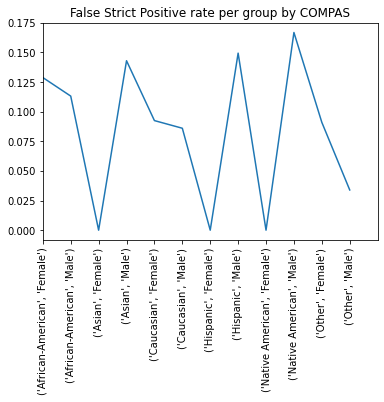

In [17]:
strictFP_list_compas=[]
for key, item in stat:
    stat_group=stat.get_group(key)
    FPos=stat_group[(((df.score_text=='High')) & (stat_group.two_year_recid==0))].count()['score_text']
    Pos=stat_group[((df.score_text=='High') | (df.score_text=='Medium'))].count()['score_text']
    if FPos==0 :
        accurecy = 0
    else:
        accurecy=FPos/Pos
    print(key,'\n',accurecy, '\n\n')
    strictFP_list_compas.append(accurecy)

plt.plot(strictFP_list_compas)
plt.xlim(0,12)
plt.xticks(range(0, 12),keys,rotation=90)
plt.title("False Strict Positive rate per group by COMPAS")

Here, by only look at the *High* risk category, we can see that *African-American* has a higher false positive rate than other races, and the *'Hispanic', 'Male'* group has the highest false positive rate overall. This means the model categorises the previously mentioned gender race combination at a higher risk than it is in reality.

('African-American', 'Female') 
 0.22382671480144403 


('African-American', 'Male') 
 0.3844714686623012 


('Asian', 'Female') 
 0.5 


('Asian', 'Male') 
 0.09090909090909091 


('Caucasian', 'Female') 
 0.2550335570469799 


('Caucasian', 'Male') 
 0.2993688007213706 


('Hispanic', 'Female') 
 0.29333333333333333 


('Hispanic', 'Male') 
 0.3003412969283277 


('Native American', 'Female') 
 0 


('Native American', 'Male') 
 0 


('Other', 'Female') 
 0.1276595744680851 


('Other', 'Male') 
 0.336283185840708 




Text(0.5, 1.0, 'False Nagative rate per group by COMPAS')

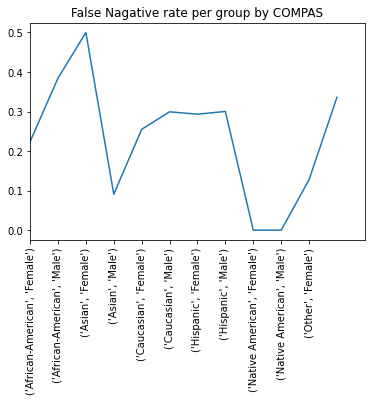

In [18]:
FN_list_compas=[]
for key, item in stat:
    stat_group=stat.get_group(key)
    FNeg=stat_group[((stat_group.score_text=='Low') & (stat_group.two_year_recid==1))].count()['score_text']
    Neg=stat_group[(stat_group.score_text=='Low')].count()['score_text']
    if FNeg==0 :
        accurecy = 0
    else:
        accurecy=FNeg/Neg
    print(key,'\n',accurecy, '\n\n')
    FN_list_compas.append(accurecy)

plt.plot(FN_list_compas)
plt.xlim(0,12)
plt.xticks(range(0, 11),keys,rotation=90)
plt.title("False Nagative rate per group by COMPAS")

There are also huge differences in terms of false negative rate per group.

## Part Two: Standard classifiers

### Preparing the data:

To make a classifier it is required that we first choose which features of the data set will act as input.
We choose for the next features:

*sex, age, race, juv_fel_count, juv_misd_count, juv_other_count, priors_count, days_b_screening_arrest, c_jail_in, c_jail_out , c_days_from_compas, c_charge_degree, in_custody, out_custody and priors_count*.

All relate to the person prior to their second crime, if there was one.
We adopted these since they represented the criminal defendants well and because they can have influence on future crime.
Likewise we assume that other features like _id_ or *c_case_number* are independent of future crimes.

Before these features can act as input to a classifier, the data will first have to be manipulated.
For example *c_jail_in* and *c_jail_out* are transformed to a new column *jail_time*, that is; the amount of day spend in jail. In the same manner *custody_time* is defined by *in_custody*  and *out_custody*.
When the defendant has not spend any time in jail or custody, then *jail_time* or *custody_time* will be 0.

In [19]:
#df = df.dropna(subset=["days_b_screening_arrest"]) #TODO remove
df=df_backup
# Fill in NAN with 0, such that the diffence in date will be 0.
df['c_jail_in'].fillna(0)
df['c_jail_out'].fillna(0)
df['in_custody'].fillna(0)
df['out_custody'].fillna(0)

length =len(df['race'])

df = df.assign(jail_time=pd.Series(np.random.randn(length)).values)
df['jail_time'] = (df['c_jail_out'].apply(pd.Timestamp) - df['c_jail_in'].apply(pd.Timestamp)).dt.days

df = df.assign(custody_time=pd.Series(np.random.randn(length)).values)
df['custody_time'] = (df['out_custody'].apply(pd.Timestamp) - df['in_custody'].apply(pd.Timestamp)).dt.days

Further some feature are expresed in strings and not number. Hence we transfer them, such that; the classifier can have them as input.

In [20]:
df['sex'].replace({'Male': 0, 'Female': 1}, inplace= True)
df['race'].replace({'African-American':0, 'Caucasian':1, 'Hispanic':2, 'Other':3, 'Asian':4, 'Native American':5}, inplace= True)
df['c_charge_degree'].replace({'F':0, 'M':1}, inplace= True)

Now we can collect the features and normalise them, because the range of possible values is different. Of course the label of the samples will be the recidivism within two years.

In [21]:
X = df[['sex', 'age', 'race', 'juv_fel_count', 'juv_misd_count', 'juv_other_count',
        'priors_count', 'days_b_screening_arrest', 'jail_time', 'c_days_from_compas', 'c_charge_degree', 'custody_time', 'priors_count']]
y = df['two_year_recid']  # Ground thruth whether they will recommit a crime or not.
print(X.head(1))

# Normalise X between [0, 1]/
X_np = X.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
X_scaled = min_max_scaler.fit_transform(X_np)
X = pd.DataFrame(X_scaled)


   sex  age  race  juv_fel_count  juv_misd_count  juv_other_count  \
0    0   69     3              0               0                0   

   priors_count  days_b_screening_arrest  jail_time  c_days_from_compas  \
0             0                     -1.0          0                 1.0   

   c_charge_degree  custody_time  priors_count  
0                0             7             0  


### Classifiers
Several classifiers will be proposed in the next section.
Every time a simple evalution performance in terms of accuracy is mentioned.

In [22]:
def accuracy(y_test, y_model):
    acc = accuracy_score(y_test, y_model)
    print('Accuracy of the network on the test samples: ' + str(acc))
    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42) #20 procent test set

#### Gaussian Naive Bayes

In [23]:
model = GaussianNB()
model.fit(X_train, y_train)
y_model = model.predict(X_test)

accuracy(y_test, y_model)

Accuracy of the network on the test samples: 0.6395301741595788


In [24]:
def label_race (idx):
    if idx==0.0 :
        return 'African-American'
    elif idx==0.2 :
        return 'Caucasian'
    elif idx==0.4 :
        return 'Hispanic'
    elif idx==0.8 :
        return 'Asian'
    elif idx==1:
        return 'Native American'
    else:
        return 'Other'
    
def label_sex (idx):
    if idx==0 :
        return 'Male'
    else :
        return 'Female'

df_Gaussian = X_test.copy()

def re_text(df,y_model,y_test):
    df['prediction']=y_model
    df['two_year_recid']=y_test

    df['sex'] = df.iloc[ : , 0 ].apply (lambda idx: label_sex(idx))
    df['race'] = df.iloc[ : , 2 ].apply (lambda idx: label_race(idx))

re_text(df_Gaussian,y_model,y_test)


In [25]:
tab = df_Gaussian[['prediction','race','sex','two_year_recid']]
stat = tab.groupby(['race', 'sex'])  
accurecy = tab[((df_Gaussian.prediction==1) & (df_Gaussian.two_year_recid==1)) | ((df_Gaussian.prediction==0) & (df_Gaussian.two_year_recid==0))].count()['prediction']/tab.count()['prediction']
print("Global accurecy", accurecy)

Global accurecy 0.6395301741595788


In [26]:
acc_list_gaussian=[]
for key, item in stat:
    stat_group=stat.get_group(key)
    TPredic=stat_group[((df_Gaussian.prediction==1) & (df_Gaussian.two_year_recid==1)) | ((df_Gaussian.prediction==0) & (df_Gaussian.two_year_recid==0))].count()['prediction']
    Predic=stat_group.count()['prediction']
    if TPredic==0 :
        accurecy = 0
    else:
        accurecy=TPredic/Predic
    print(key,'\n',accurecy, '\n\n')
    acc_list_gaussian.append(accurecy)

('African-American', 'Female') 
 0.6858407079646017 


('African-American', 'Male') 
 0.622478386167147 


('Asian', 'Male') 
 0.7857142857142857 


('Caucasian', 'Female') 
 0.6510416666666666 


('Caucasian', 'Male') 
 0.6427480916030535 


('Hispanic', 'Female') 
 0.7058823529411765 


('Hispanic', 'Male') 
 0.6467065868263473 


('Native American', 'Female') 
 0 


('Native American', 'Male') 
 1.0 


('Other', 'Female') 
 0.7142857142857143 


('Other', 'Male') 
 0.5925925925925926 




/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


We can see here the accuracy differences per group are still present. Comparing to the result from COMPAS, there's no major improvement, the differences between some groups has even been enlarged.

In [27]:
FP_list_gaussian=[]
for key, item in stat:
    stat_group=stat.get_group(key)
    FPos=stat_group[((stat_group.prediction==1) & (stat_group.two_year_recid==0))].count()['prediction']
    Pos=stat_group[(stat_group.prediction==1)].count()['prediction']
    if FPos==0 :
        accurecy = 0
    else:
        accurecy=FPos/Pos
    print(key,'\n',accurecy, '\n\n')
    FP_list_gaussian.append(accurecy)

('African-American', 'Female') 
 0.2727272727272727 


('African-American', 'Male') 
 0.2729528535980149 


('Asian', 'Male') 
 0 


('Caucasian', 'Female') 
 0.2857142857142857 


('Caucasian', 'Male') 
 0.3904761904761905 


('Hispanic', 'Female') 
 0 


('Hispanic', 'Male') 
 0.5 


('Native American', 'Female') 
 0 


('Native American', 'Male') 
 0 


('Other', 'Female') 
 1.0 


('Other', 'Male') 
 0.5454545454545454 




In [28]:
FN_list_gaussian=[]
for key, item in stat:
    stat_group=stat.get_group(key)
    FNeg=stat_group[((stat_group.prediction==0) & (stat_group.two_year_recid==1))].count()['prediction']
    Neg=stat_group[(stat_group.prediction==0)].count()['prediction']
    if FNeg==0 :
        accurecy = 0
    else:
        accurecy=FNeg/Neg
    print(key,'\n',accurecy, '\n\n')
    FN_list_gaussian.append(accurecy)

('African-American', 'Female') 
 0.31862745098039214 


('African-American', 'Male') 
 0.44357366771159873 


('Asian', 'Male') 
 0.23076923076923078 


('Caucasian', 'Female') 
 0.3539325842696629 


('Caucasian', 'Male') 
 0.3509090909090909 


('Hispanic', 'Female') 
 0.30303030303030304 


('Hispanic', 'Male') 
 0.32867132867132864 


('Native American', 'Female') 
 1.0 


('Native American', 'Male') 
 0 


('Other', 'Female') 
 0.23076923076923078 


('Other', 'Male') 
 0.3917525773195876 




#### K-Nearest Neighbours
By increasing the number of neighbours the accuracy increases. Yet at a certain point every entry might be classified as the most probable class in the entire dataset, because k is so large. Resulting in a negative effect on the accuracy. We dicovered that this occurs when k is 55.

In [29]:
model = KNeighborsClassifier(n_neighbors=55)
model.fit(X_train, y_train)
y_model = model.predict(X_test)

accuracy(y_test, y_model)

Accuracy of the network on the test samples: 0.6723369785338194


In [30]:
df_KNN = X_test.copy()
re_text(df_KNN,y_model,y_test)

In [31]:
tab = df_KNN[['prediction','race','sex','two_year_recid']]
stat = tab.groupby(['race', 'sex'])  
accurecy = tab[((df_KNN.prediction==1) & (df_KNN.two_year_recid==1)) | ((df_KNN.prediction==0) & (df_KNN.two_year_recid==0))].count()['prediction']/tab.count()['prediction']
print("Global accurecy", accurecy)

Global accurecy 0.6723369785338194


In [32]:
acc_list_knn=[]
for key, item in stat:
    stat_group=stat.get_group(key)
    TPredic=stat_group[((stat_group.prediction==1) & (stat_group.two_year_recid==1)) | ((stat_group.prediction==0) & (stat_group.two_year_recid==0))].count()['prediction']
    Predic=stat_group.count()['prediction']
    if TPredic==0 :
        accurecy = 0
    else:
        accurecy=TPredic/Predic
    print(key,'\n',accurecy, '\n\n')
    acc_list_knn.append(accurecy)

('African-American', 'Female') 
 0.6769911504424779 


('African-American', 'Male') 
 0.681075888568684 


('Asian', 'Male') 
 0.7142857142857143 


('Caucasian', 'Female') 
 0.6510416666666666 


('Caucasian', 'Male') 
 0.6625954198473283 


('Hispanic', 'Female') 
 0.7058823529411765 


('Hispanic', 'Male') 
 0.6946107784431138 


('Native American', 'Female') 
 0 


('Native American', 'Male') 
 1.0 


('Other', 'Female') 
 0.7857142857142857 


('Other', 'Male') 
 0.5925925925925926 




Here we can observe a much more even accuracy among groups. With the majority of the accuracy better than COMPAS. Next, we are going to examine the false positive rate and false negative rate group by group.

In [33]:
FP_list_knn=[]
for key, item in stat:
    stat_group=stat.get_group(key)
    FPos=stat_group[((stat_group.prediction==1) & (stat_group.two_year_recid==0))].count()['prediction']
    Pos=stat_group[(stat_group.prediction==1)].count()['prediction']
    if FPos==0 :
        accurecy = 0
    else:
        accurecy=FPos/Pos
    print(key,'\n',accurecy, '\n\n')
    FP_list_knn.append(accurecy)

('African-American', 'Female') 
 0.35714285714285715 


('African-American', 'Male') 
 0.3006535947712418 


('Asian', 'Male') 
 0 


('Caucasian', 'Female') 
 0.25 


('Caucasian', 'Male') 
 0.3732394366197183 


('Hispanic', 'Female') 
 0 


('Hispanic', 'Male') 
 0.42 


('Native American', 'Female') 
 0 


('Native American', 'Male') 
 0 


('Other', 'Female') 
 0 


('Other', 'Male') 
 0.5333333333333333 




In [34]:
FN_list_knn=[]
for key, item in stat:
    stat_group=stat.get_group(key)
    FNeg=stat_group[((stat_group.prediction==0) & (stat_group.two_year_recid==1))].count()['prediction']
    Neg=stat_group[(stat_group.prediction==0)].count()['prediction']
    if FNeg==0 :
        accurecy = 0
    else:
        accurecy=FNeg/Neg
    print(key,'\n',accurecy, '\n\n')
    FN_list_knn.append(accurecy)

('African-American', 'Female') 
 0.3181818181818182 


('African-American', 'Male') 
 0.34498834498834496 


('Asian', 'Male') 
 0.2857142857142857 


('Caucasian', 'Female') 
 0.35555555555555557 


('Caucasian', 'Male') 
 0.32748538011695905 


('Hispanic', 'Female') 
 0.30303030303030304 


('Hispanic', 'Male') 
 0.2564102564102564 


('Native American', 'Female') 
 1.0 


('Native American', 'Male') 
 0 


('Other', 'Female') 
 0.21428571428571427 


('Other', 'Male') 
 0.3870967741935484 




#### Multi Layer Perceptron
A multi layer perceptron (MLP) appeared to have a better accuracy when there are more nodes in the hidden layers and when using relu as teh activation function.

In [35]:
classifier = MLPClassifier(hidden_layer_sizes=(150,100,50), activation='relu', solver='adam', max_iter=2000)
classifier.fit(X_train, y_train)
y_model = classifier.predict(X_test)

accuracy(y_test, y_model)

Accuracy of the network on the test samples: 0.6662616443904414


In [36]:
df_MLP = X_test.copy()
re_text(df_MLP,y_model,y_test)

In [37]:
tab = df_MLP[['prediction','race','sex','two_year_recid']]
stat = tab.groupby(['race', 'sex'])  
accurecy = tab[((df_MLP.prediction==1) & (df_MLP.two_year_recid==1)) | ((df_MLP.prediction==0) & (df_MLP.two_year_recid==0))].count()['prediction']/tab.count()['prediction']
print("Global accurecy", accurecy)

Global accurecy 0.6662616443904414


In [38]:
acc_list_mlp=[]
for key, item in stat:
    stat_group=stat.get_group(key)
    TPredic=stat_group[((stat_group.prediction==1) & (stat_group.two_year_recid==1)) | ((stat_group.prediction==0) & (stat_group.two_year_recid==0))].count()['prediction']
    Predic=stat_group.count()['prediction']
    if TPredic==0 :
        accurecy = 0
    else:
        accurecy=TPredic/Predic
    print(key,'\n',accurecy, '\n\n')
    acc_list_mlp.append(accurecy)

('African-American', 'Female') 
 0.7035398230088495 


('African-American', 'Male') 
 0.6570605187319885 


('Asian', 'Male') 
 0.7857142857142857 


('Caucasian', 'Female') 
 0.6458333333333334 


('Caucasian', 'Male') 
 0.6793893129770993 


('Hispanic', 'Female') 
 0.6764705882352942 


('Hispanic', 'Male') 
 0.6167664670658682 


('Native American', 'Female') 
 1.0 


('Native American', 'Male') 
 1.0 


('Other', 'Female') 
 0.7857142857142857 


('Other', 'Male') 
 0.6481481481481481 




We can observe a high performance here using the Multi Layer Perceptron, but the accuracy per group graph clearly shows an inequality among groups

In [39]:
FP_list_mlp=[]
for key, item in stat:
    stat_group=stat.get_group(key)
    FPos=stat_group[((stat_group.prediction==1) & (stat_group.two_year_recid==0))].count()['prediction']
    Pos=stat_group[(stat_group.prediction==1)].count()['prediction']
    if FPos==0 :
        accurecy = 0
    else:
        accurecy=FPos/Pos
    print(key,'\n',accurecy, '\n\n')
    FP_list_mlp.append(accurecy)

('African-American', 'Female') 
 0.28125 


('African-American', 'Male') 
 0.3027027027027027 


('Asian', 'Male') 
 0.3333333333333333 


('Caucasian', 'Female') 
 0.38095238095238093 


('Caucasian', 'Male') 
 0.38071065989847713 


('Hispanic', 'Female') 
 0.5 


('Hispanic', 'Male') 
 0.5384615384615384 


('Native American', 'Female') 
 0 


('Native American', 'Male') 
 0 


('Other', 'Female') 
 0.5 


('Other', 'Male') 
 0.44680851063829785 




In [40]:
FN_list_mlp=[]
for key, item in stat:
    stat_group=stat.get_group(key)
    FNeg=stat_group[((stat_group.prediction==0) & (stat_group.two_year_recid==1))].count()['prediction']
    Neg=stat_group[(stat_group.prediction==0)].count()['prediction']
    if FNeg==0 :
        accurecy = 0
    else:
        accurecy=FNeg/Neg
    print(key,'\n',accurecy, '\n\n')
    FN_list_mlp.append(accurecy)

('African-American', 'Female') 
 0.29896907216494845 


('African-American', 'Male') 
 0.3888888888888889 


('Asian', 'Male') 
 0.18181818181818182 


('Caucasian', 'Female') 
 0.3508771929824561 


('Caucasian', 'Male') 
 0.29475982532751094 


('Hispanic', 'Female') 
 0.3125 


('Hispanic', 'Male') 
 0.28431372549019607 


('Native American', 'Female') 
 0 


('Native American', 'Male') 
 0 


('Other', 'Female') 
 0.16666666666666666 


('Other', 'Male') 
 0.2786885245901639 




#### Linear Regression
Linear regression required to round the output in order to still have a binary classifier. This model definedly performed very good in terms of accuracy.

In [41]:
model = LinearRegression(fit_intercept=True)
model.fit(X_train, y_train)
y_model = (model.predict(X_test)).round()

accuracy(y_test, y_model)

Accuracy of the network on the test samples: 0.6844876468205752


In [42]:
df_LR = X_test.copy()
re_text(df_LR,y_model,y_test)

In [43]:
tab = df_LR[['prediction','race','sex','two_year_recid']]
stat = tab.groupby(['race', 'sex'])  
accurecy = tab[((df_LR.prediction>0.5) & (df_LR.two_year_recid==1)) | ((df_LR.prediction<=0.5) & (df_LR.two_year_recid==0))].count()['prediction']/tab.count()['prediction']
print("Global accurecy", accurecy)

Global accurecy 0.6861077359254759


In [44]:
acc_list_lr=[]
for key, item in stat:
    stat_group=stat.get_group(key)
    TPredic=stat_group[((stat_group.prediction>0.5) & (stat_group.two_year_recid==1)) | ((stat_group.prediction<=0.5) & (stat_group.two_year_recid==0))].count()['prediction']
    Predic=stat_group.count()['prediction']
    if TPredic==0 :
        accurecy = 0
    else:
        accurecy=TPredic/Predic
    print(key,'\n',accurecy, '\n\n')
    acc_list_lr.append(accurecy)

('African-American', 'Female') 
 0.7123893805309734 


('African-American', 'Male') 
 0.6820365033621518 


('Asian', 'Male') 
 0.7142857142857143 


('Caucasian', 'Female') 
 0.6822916666666666 


('Caucasian', 'Male') 
 0.6748091603053435 


('Hispanic', 'Female') 
 0.7058823529411765 


('Hispanic', 'Male') 
 0.7544910179640718 


('Native American', 'Female') 
 0 


('Native American', 'Male') 
 1.0 


('Other', 'Female') 
 0.7857142857142857 


('Other', 'Male') 
 0.6018518518518519 




In [45]:
FP_list_lr=[]
for key, item in stat:
    stat_group=stat.get_group(key)
    FPos=stat_group[((stat_group.prediction>0.5) & (stat_group.two_year_recid==0))].count()['prediction']
    Pos=stat_group[(stat_group.prediction>0.5)].count()['prediction']
    if FPos==0 :
        accurecy = 0
    else:
        accurecy=FPos/Pos
    print(key,'\n',accurecy, '\n\n')
    FP_list_lr.append(accurecy)

('African-American', 'Female') 
 0.23333333333333334 


('African-American', 'Male') 
 0.2995090016366612 


('Asian', 'Male') 
 0 


('Caucasian', 'Female') 
 0.16666666666666666 


('Caucasian', 'Male') 
 0.358974358974359 


('Hispanic', 'Female') 
 0 


('Hispanic', 'Male') 
 0.2631578947368421 


('Native American', 'Female') 
 0 


('Native American', 'Male') 
 0 


('Other', 'Female') 
 0 


('Other', 'Male') 
 0.5 




In [46]:
FN_list_lr=[]
for key, item in stat:
    stat_group=stat.get_group(key)
    FNeg=stat_group[((stat_group.prediction<=0.5) & (stat_group.two_year_recid==1))].count()['prediction']
    Neg=stat_group[(stat_group.prediction<=0.5)].count()['prediction']
    if FNeg==0 :
        accurecy = 0
    else:
        accurecy=FNeg/Neg
    print(key,'\n',accurecy, '\n\n')
    FN_list_lr.append(accurecy)

('African-American', 'Female') 
 0.29591836734693877 


('African-American', 'Male') 
 0.34418604651162793 


('Asian', 'Male') 
 0.2857142857142857 


('Caucasian', 'Female') 
 0.3333333333333333 


('Caucasian', 'Male') 
 0.31462925851703405 


('Hispanic', 'Female') 
 0.30303030303030304 


('Hispanic', 'Male') 
 0.24031007751937986 


('Native American', 'Female') 
 1.0 


('Native American', 'Male') 
 0 


('Other', 'Female') 
 0.21428571428571427 


('Other', 'Male') 
 0.375 




#### Neural Network with dense layers.

An other classifier is a neural network existing out of three dense layers using the relu activation function.
At the end of the network a sigoid function is applied.

To train this network, we add a dimension to the *X_train* and *X_test* and turn our training and test sets to tensors. Further we create the dataloaders *trainloader* and *testloader* to iterate easily over the dataset during training.

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42) #20 precent test set

df_NN = X_test
df_CNN = X_test

X_train = torch.from_numpy(X_train.to_numpy()).float()
X_train.unsqueeze_(1)
y_train = torch.squeeze(torch.from_numpy(y_train.to_numpy()).float())

dataset_train = dt.TensorDataset(X_train, y_train)
trainloader = dt.DataLoader(dataset_train, batch_size=5, shuffle=True, num_workers=2) # Let the amount of training samples be dividable by the batch size 


X_test = torch.from_numpy(X_test.to_numpy()).float()
X_test.unsqueeze_(1)
y_test = torch.squeeze(torch.from_numpy(y_test.to_numpy()).float())

dataset_test = dt.TensorDataset(X_test, y_test)
testloader = dt.DataLoader(dataset_test, batch_size=5, shuffle=True, num_workers=2)


print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([3703, 1, 13]) torch.Size([3703])
torch.Size([2469, 1, 13]) torch.Size([2469])


In [48]:
class Net_dense(nn.Module):

    def __init__(self, n_features):
        super(Net_dense, self).__init__()
        self.fc1 = nn.Linear(n_features, 8)
        self.fc2 = nn.Linear(8, 5)
        self.fc3 = nn.Linear(5, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return torch.sigmoid(self.fc3(x))
net_dense = Net_dense(X_train.shape[2])
print(net_dense)


Net_dense(
  (fc1): Linear(in_features=13, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=5, bias=True)
  (fc3): Linear(in_features=5, out_features=1, bias=True)
)


Furthermore the learning rate is 0.001 and the loss fuction is the Binary Cross Entropy.
The following functions allow to train the given network and to predict the labels of the test set. Then we train the network and compute the accuracy.

In [49]:
criterion_dense = nn.BCELoss()
optimizer_dense = optim.SGD(net_dense.parameters(), lr=0.001, momentum=0.9)

In [50]:
def train(trainloader, net, criterion, optimizer):
    for epoch in range(12):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net.forward(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # print statistics
            running_loss += loss.item()
            if i % 99 == 0:    # print every 100 mini-batches of 4 trainling examples
                print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0    

In [51]:
def predict (net, testloader):
    y_pred_list = []
    with torch.no_grad():
        for data in testloader:
            samples, labels = data
            y_test_pred = net(samples)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.numpy())
    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    y_model = [item for sublist in y_pred_list for item in sublist]
    return y_model    

In [52]:
train(trainloader, net_dense, criterion_dense, optimizer_dense)

[1,     1] loss: 0.000


/usr/local/lib/python3.7/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([5])) that is different to the input size (torch.Size([5, 1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


[1,   100] loss: 0.034
[1,   199] loss: 0.034
[1,   298] loss: 0.034
[1,   397] loss: 0.034
[1,   496] loss: 0.034
[1,   595] loss: 0.034
[1,   694] loss: 0.034


/usr/local/lib/python3.7/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


[2,     1] loss: 0.000
[2,   100] loss: 0.034
[2,   199] loss: 0.034
[2,   298] loss: 0.034
[2,   397] loss: 0.034
[2,   496] loss: 0.034
[2,   595] loss: 0.034
[2,   694] loss: 0.034
[3,     1] loss: 0.000
[3,   100] loss: 0.034
[3,   199] loss: 0.034
[3,   298] loss: 0.034
[3,   397] loss: 0.034
[3,   496] loss: 0.034
[3,   595] loss: 0.034
[3,   694] loss: 0.034
[4,     1] loss: 0.000
[4,   100] loss: 0.034
[4,   199] loss: 0.034
[4,   298] loss: 0.034
[4,   397] loss: 0.034
[4,   496] loss: 0.034
[4,   595] loss: 0.034
[4,   694] loss: 0.034
[5,     1] loss: 0.000
[5,   100] loss: 0.034
[5,   199] loss: 0.034
[5,   298] loss: 0.034
[5,   397] loss: 0.034
[5,   496] loss: 0.034
[5,   595] loss: 0.034
[5,   694] loss: 0.034
[6,     1] loss: 0.000
[6,   100] loss: 0.034
[6,   199] loss: 0.034
[6,   298] loss: 0.034
[6,   397] loss: 0.034
[6,   496] loss: 0.034
[6,   595] loss: 0.034
[6,   694] loss: 0.034
[7,     1] loss: 0.000
[7,   100] loss: 0.034
[7,   199] loss: 0.034
[7,   298] 

In [53]:
y_model = predict (net_dense, testloader)
accuracy(y_test, y_model)

Accuracy of the network on the test samples: 0.5002025111381126


In [54]:
re_text(df_NN,y_model,y_test)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

In [55]:
tab = df_NN[['prediction','race','sex','two_year_recid']]
stat = tab.groupby(['race', 'sex'])  
accurecy = tab[((df_NN.prediction==1) & (df_NN.two_year_recid==1)) | ((df_NN.prediction==0) & (df_NN.two_year_recid==0))].count()['prediction']/tab.count()['prediction']
print("Global accurecy", accurecy)

Global accurecy 0.5002025111381126


In [56]:
acc_list_nn=[]
for key, item in stat:
    stat_group=stat.get_group(key)
    TPredic=stat_group[((stat_group.prediction>0.5) & (stat_group.two_year_recid==1)) | ((stat_group.prediction<=0.5) & (stat_group.two_year_recid==0))].count()['prediction']
    Predic=stat_group.count()['prediction']
    if TPredic==0 :
        accurecy = 0
    else:
        accurecy=TPredic/Predic
    print(key,'\n',accurecy, '\n\n')
    acc_list_nn.append(accurecy)

('African-American', 'Female') 
 0.5309734513274337 


('African-American', 'Male') 
 0.484149855907781 


('Asian', 'Male') 
 0.2857142857142857 


('Caucasian', 'Female') 
 0.53125 


('Caucasian', 'Male') 
 0.5022900763358779 


('Hispanic', 'Female') 
 0.5882352941176471 


('Hispanic', 'Male') 
 0.5149700598802395 


('Native American', 'Female') 
 0 


('Native American', 'Male') 
 0 


('Other', 'Female') 
 0.4642857142857143 


('Other', 'Male') 
 0.5277777777777778 




In [57]:
FP_list_nn=[]
for key, item in stat:
    stat_group=stat.get_group(key)
    FPos=stat_group[((stat_group.prediction>0.5) & (stat_group.two_year_recid==0))].count()['prediction']
    print(FPos)
    Pos=stat_group[(stat_group.prediction>0.5)].count()['prediction']
    print(Pos)
    if FPos==0 :
        accurecy = 0
    else:
        accurecy=FPos/Pos
    print(key,'\n',accurecy, '\n\n')
    FP_list_nn.append(accurecy)

53
81
('African-American', 'Female') 
 0.654320987654321 


168
375
('African-American', 'Male') 
 0.448 


6
6
('Asian', 'Male') 
 1.0 


42
67
('Caucasian', 'Female') 
 0.6268656716417911 


152
235
('Caucasian', 'Male') 
 0.6468085106382979 


7
11
('Hispanic', 'Female') 
 0.6363636363636364 


44
66
('Hispanic', 'Male') 
 0.6666666666666666 


0
0
('Native American', 'Female') 
 0 


3
3
('Native American', 'Male') 
 1.0 


11
13
('Other', 'Female') 
 0.8461538461538461 


26
44
('Other', 'Male') 
 0.5909090909090909 




In [58]:
FN_list_nn=[]
for key, item in stat:
    stat_group=stat.get_group(key)
    FNeg=stat_group[((stat_group.prediction<=0.5) & (stat_group.two_year_recid==1))].count()['prediction']
    Neg=stat_group[(stat_group.prediction<=0.5)].count()['prediction']
    if FNeg==0 :
        accurecy = 0
    else:
        accurecy=FNeg/Neg
    print(key,'\n',accurecy, '\n\n')
    FN_list_nn.append(accurecy)

('African-American', 'Female') 
 0.36551724137931035 


('African-American', 'Male') 
 0.5540540540540541 


('Asian', 'Male') 
 0.5 


('Caucasian', 'Female') 
 0.384 


('Caucasian', 'Male') 
 0.4142857142857143 


('Hispanic', 'Female') 
 0.30434782608695654 


('Hispanic', 'Male') 
 0.36633663366336633 


('Native American', 'Female') 
 1.0 


('Native American', 'Male') 
 0 


('Other', 'Female') 
 0.26666666666666666 


('Other', 'Male') 
 0.390625 




#### CNN

Further we try a Convolutional Neural Network. The CNN is not the best solution to the problem, since there are only a few features and each convolution layer reduces the amount of features incredibly. Because of this problem the kernel_size cannot be further increased, resulting in a poor accuracy.

In [59]:
class Net_CNN(nn.Module):

    def __init__(self, n_features):
        super(Net_CNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 16, kernel_size=2,stride=1, padding=0)
        self.conv2 = nn.Conv1d(16, 64, kernel_size=2,stride=1, padding=0)
        self.fc1 = nn.Linear(128, 64)       # Dense / Fully connnected layer.
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
        
    def forward(self, x):
        x = F.max_pool1d(F.relu(self.conv1(x)), kernel_size=2)
        x = F.max_pool1d(F.relu(self.conv2(x)), kernel_size=2)
        x = x.view(-1, self.num_flat_features(x))               # Flatten
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x
    
net_CNN = Net_CNN(X_train.shape[1])
print(net_CNN)

Net_CNN(
  (conv1): Conv1d(1, 16, kernel_size=(2,), stride=(1,))
  (conv2): Conv1d(16, 64, kernel_size=(2,), stride=(1,))
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
)


In [60]:
criterion_cnn = nn.BCELoss()
optimizer_cnn = optim.SGD(net_CNN.parameters(), lr=0.001, momentum=0.9)

In [61]:
train(trainloader, net_CNN, criterion_cnn, optimizer_cnn)

[1,     1] loss: 0.000


/usr/local/lib/python3.7/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([5])) that is different to the input size (torch.Size([5, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


[1,   100] loss: 0.034
[1,   199] loss: 0.034
[1,   298] loss: 0.034
[1,   397] loss: 0.034
[1,   496] loss: 0.034
[1,   595] loss: 0.034
[1,   694] loss: 0.034


/usr/local/lib/python3.7/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


[2,     1] loss: 0.000
[2,   100] loss: 0.034
[2,   199] loss: 0.034
[2,   298] loss: 0.034
[2,   397] loss: 0.034
[2,   496] loss: 0.034
[2,   595] loss: 0.034
[2,   694] loss: 0.034
[3,     1] loss: 0.000
[3,   100] loss: 0.034
[3,   199] loss: 0.034
[3,   298] loss: 0.034
[3,   397] loss: 0.034
[3,   496] loss: 0.034
[3,   595] loss: 0.034
[3,   694] loss: 0.034
[4,     1] loss: 0.000
[4,   100] loss: 0.034
[4,   199] loss: 0.034
[4,   298] loss: 0.034
[4,   397] loss: 0.035
[4,   496] loss: 0.034
[4,   595] loss: 0.034
[4,   694] loss: 0.034
[5,     1] loss: 0.000
[5,   100] loss: 0.034
[5,   199] loss: 0.034
[5,   298] loss: 0.034
[5,   397] loss: 0.034
[5,   496] loss: 0.034
[5,   595] loss: 0.034
[5,   694] loss: 0.034
[6,     1] loss: 0.000
[6,   100] loss: 0.034
[6,   199] loss: 0.034
[6,   298] loss: 0.034
[6,   397] loss: 0.034
[6,   496] loss: 0.034
[6,   595] loss: 0.034
[6,   694] loss: 0.034
[7,     1] loss: 0.000
[7,   100] loss: 0.034
[7,   199] loss: 0.034
[7,   298] 

In [62]:
y_model = predict (net_CNN, testloader)
accuracy(y_test, y_model)

Accuracy of the network on the test samples: 0.5520453624949372


In [63]:
re_text(df_CNN,y_model,y_test)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

In [64]:
tab = df_CNN[['prediction','race','sex','two_year_recid']]
stat = tab.groupby(['race', 'sex'])  
accurecy = tab[((df_CNN.prediction>0.5) & (df_CNN.two_year_recid==1)) | ((df_CNN.prediction<=0.5) & (df_CNN.two_year_recid==0))].count()['prediction']/tab.count()['prediction']
print("Global accurecy", accurecy)

Global accurecy 0.5520453624949372


In [65]:
acc_list_cnn=[]
for key, item in stat:
    stat_group=stat.get_group(key)
    TPredic=stat_group[((stat_group.prediction>0.5) & (stat_group.two_year_recid==1)) | ((stat_group.prediction<=0.5) & (stat_group.two_year_recid==0))].count()['prediction']
    Predic=stat_group.count()['prediction']
    if TPredic==0 :
        accurecy = 0
    else:
        accurecy=TPredic/Predic
    print(key,'\n',accurecy, '\n\n')
    acc_list_cnn.append(accurecy)

('African-American', 'Female') 
 0.6327433628318584 


('African-American', 'Male') 
 0.4543707973102786 


('Asian', 'Male') 
 0.7142857142857143 


('Caucasian', 'Female') 
 0.609375 


('Caucasian', 'Male') 
 0.6091603053435114 


('Hispanic', 'Female') 
 0.7058823529411765 


('Hispanic', 'Male') 
 0.6347305389221557 


('Native American', 'Female') 
 0 


('Native American', 'Male') 
 1.0 


('Other', 'Female') 
 0.7857142857142857 


('Other', 'Male') 
 0.6111111111111112 




In [66]:
FP_list_cnn=[]
for key, item in stat:
    stat_group=stat.get_group(key)
    FPos=stat_group[((stat_group.prediction==1) & (stat_group.two_year_recid==0))].count()['prediction']
    Pos=stat_group[(stat_group.prediction==1)].count()['prediction']
    if FPos==0 :
        accurecy = 0
    else:
        accurecy=FPos/Pos
    print(key,'\n',accurecy, '\n\n')
    FP_list_cnn.append(accurecy)

('African-American', 'Female') 
 0.75 


('African-American', 'Male') 
 0.35714285714285715 


('Asian', 'Male') 
 0 


('Caucasian', 'Female') 
 0.75 


('Caucasian', 'Male') 
 0.47058823529411764 


('Hispanic', 'Female') 
 0 


('Hispanic', 'Male') 
 0.6666666666666666 


('Native American', 'Female') 
 0 


('Native American', 'Male') 
 0 


('Other', 'Female') 
 0.5 


('Other', 'Male') 
 0.3333333333333333 




In [67]:
FN_list_cnn=[]
for key, item in stat:
    stat_group=stat.get_group(key)
    FNeg=stat_group[((stat_group.prediction<=0.5) & (stat_group.two_year_recid==1))].count()['prediction']
    Neg=stat_group[(stat_group.prediction<=0.5)].count()['prediction']
    if FNeg==0 :
        accurecy = 0
    else:
        accurecy=FNeg/Neg
    print(key,'\n',accurecy, '\n\n')
    FN_list_cnn.append(accurecy)

('African-American', 'Female') 
 0.36036036036036034 


('African-American', 'Male') 
 0.5508390918065152 


('Asian', 'Male') 
 0.2857142857142857 


('Caucasian', 'Female') 
 0.3829787234042553 


('Caucasian', 'Male') 
 0.3887147335423197 


('Hispanic', 'Female') 
 0.30303030303030304 


('Hispanic', 'Male') 
 0.35403726708074534 


('Native American', 'Female') 
 1.0 


('Native American', 'Male') 
 0 


('Other', 'Female') 
 0.19230769230769232 


('Other', 'Male') 
 0.3904761904761905 




### Comparison

The table below summarises the accuracies for each classifier.

| **Classifier**       | **Accuracy**     |
| :------------- | :----------: |
|  Gaussian Naive Bayes | 0.6005788712011577  |
| K-Nearest Neighbours   | 0.6657018813314037 |
| Multi Layer Percerptron |  0.6490593342981187  |
|  Linear Regression | 0.670767004341534  |
|  Dense Neural Network | 0.5332850940665702 |
|  Convolutional Neural Network | 0.5332850940665702 |
|  Compas Binary Classifier  |  0.6597654553351672 |

Seems all models performed very close to each other, except for the two Neural Networks. We will take a deeper look into their performance per group blow.

We are going to plot the accuracy, FP and FN per group blow. We removed the *Asain female* group from the results we got COMPAS because this group only have 2 samples and never got picked in the test set for our classifier so we have no prediction on this group

Text(0.5, 1.0, 'Accuracy per group')

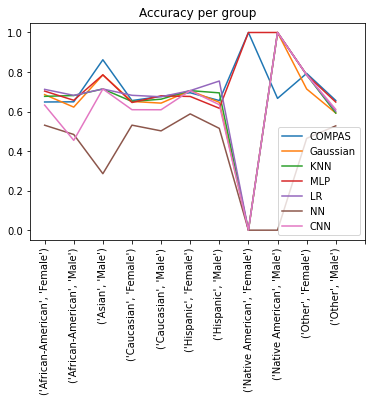

In [68]:

#accurecy per group all

del acc_list_compas[2]
del keys[2]

plt.plot(acc_list_compas,label="COMPAS")
plt.plot(acc_list_gaussian,label="Gaussian")
plt.plot(acc_list_knn,label="KNN")
plt.plot(acc_list_mlp,label="MLP")
plt.plot(acc_list_lr,label="LR")
plt.plot(acc_list_nn,label="NN")
plt.plot(acc_list_cnn,label="CNN")
plt.legend(loc='best')
plt.xticks(range(0, 12),keys,rotation=90)
plt.title("Accuracy per group")

We can see here that all models here performed almost as good as the COMPAS classifier in terms of accuracy. Inequality among groups are still more or less present in all groups

Text(0.5, 1.0, 'False positive per group')

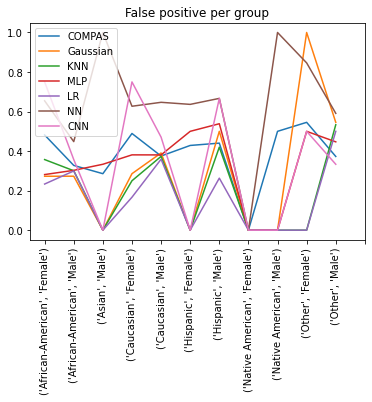

In [69]:

#false positive per group all

del FP_list_compas[2]

plt.plot(FP_list_compas,label="COMPAS")
plt.plot(FP_list_gaussian,label="Gaussian")
plt.plot(FP_list_knn,label="KNN")
plt.plot(FP_list_mlp,label="MLP")
plt.plot(FP_list_lr,label="LR")
plt.plot(FP_list_nn,label="NN")
plt.plot(FP_list_cnn,label="CNN")
plt.legend(loc='best')
plt.xticks(range(0, 12),keys,rotation=90)
plt.title("False positive per group")

The false positive rate shows a more diverge among classifiers. Still, Inequality among groups are still more or less present in all groups.

Text(0.5, 1.0, 'False negative per group')

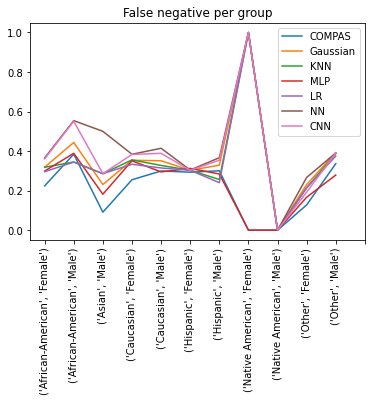

In [70]:

#false negative per group all

del FN_list_compas[2]

plt.plot(FN_list_compas,label="COMPAS")
plt.plot(FN_list_gaussian,label="Gaussian")
plt.plot(FN_list_knn,label="KNN")
plt.plot(FN_list_mlp,label="MLP")
plt.plot(FN_list_lr,label="LR")
plt.plot(FN_list_nn,label="NN")
plt.plot(FN_list_cnn,label="CNN")
plt.legend(loc='best')
plt.xticks(range(0, 12),keys,rotation=90)
plt.title("False negative per group")

Here we notice that almost no classifier outperforms the CAMPAS one in terms of false negative rate. Could be a deliberate decision on COMPAS' part.

### Fairness critiria
We took the 2 conventional criteria of fairness: independence and separation with the following definition:
        - Independence: If a feature is statistically independent to the prediction result.
        - Separation: If a feature is statistically independent to the prediction result with a given target value (example false positive rate) of the prediction. This means the false positive rate and the false negative rate should be equal in all groups.

We will use these 2 criteria to examine the COMPAS data first

In [71]:

#Independence criteria


df=df_backup
df['sex'].replace({'Male': 0, 'Female': 1}, inplace= True)
df['race'].replace({'African-American':0, 'Caucasian':1, 'Hispanic':2, 'Other':3, 'Asian':4, 'Native American':5}, inplace= True)
df['c_charge_degree'].replace({'F':0, 'M':1}, inplace= True)
sex = df['sex']
race = df['race']
two_year_recid = df['two_year_recid']
prediction = df['decile_score']

print(sex.dtype)

correlation_matrix = np.corrcoef([sex,race,two_year_recid,prediction])
print(correlation_matrix)

int64
[[ 1.          0.00638145 -0.10091102 -0.06057473]
 [ 0.00638145  1.         -0.12383131 -0.27744237]
 [-0.10091102 -0.12383131  1.          0.36548711]
 [-0.06057473 -0.27744237  0.36548711  1.        ]]


From the matrix above we can observe that decile_score is correlated with both race and gender(less strong). This means the classifier does not fit the independence criteria. We can also observe that the two_year_recid is also correlated with race and gender, this indicates that the dataset is biased from the beginning, this bias needs to be corrected before training.

Separation criteria
We can observe the inequality among groups in terms of false positive rate and false negative rate in the previous plot in the first section. COMPAS does not fit this criteria either

## Part Three
Reference: https://faculty.ai/blog/how-to-repair-an-unfair-classifier-part-1/

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) #20 procent test set
model = KNeighborsClassifier(n_neighbors=55)
model.fit(X_train, y_train)

X_train_male = X_train.loc[X_train[0] == 0]
X_train_female = X_train.loc[X_train[0] == 1]

score_male_tupel = model.predict_proba(X_train_male)
score_female_tupel = model.predict_proba(X_train_female)
#model.predict_proba(X_train_female)

scores_male = [item[1] for item in score_male_tupel]
scores_female = [item[1] for item in score_female_tupel]

xbins = np.linspace(0, 1, 2**10)
x = (xbins[1:] + xbins[:-1])/2  # midpoint of each bin
dx = xbins[1:] - xbins[:-1]
y_male, _ = np.histogram(scores_male, density=True, bins=xbins)
y_female, _ = np.histogram(scores_female, density=True, bins=xbins)

# Cumulative distributions:
f_male = y_male.cumsum()*dx
f_female = y_female.cumsum()*dx

f_space = np.linspace(0,1, 2**9) 
x_med = np.zeros_like(f_space)
for i, f in enumerate(f_space):
    a_arg = np.abs(f_male - f).argmin()
    b_arg = np.abs(f_female - f).argmin()
    x_med[i] = np.median([x[a_arg], x[b_arg]])
    
def repair_score(score, entry, x_med, f_male, f_female):
    x_arg = np.abs(x - score).argmin()
    if entry.iloc[0] == 0:    
        f_val = f_male[x_arg]
    elif entry.iloc[0] == 1:
        f_val = f_female[x_arg]

    f_arg = np.abs(f_space - f_val).argmin()
    r_new = x_med[f_arg]
    return r_new
probability = model.predict_proba(X_test)
#final_score = repair_score(probability[0][1], X_test, x_med, f_male, f_female)

final_score = []
for i in range(len(X_test)):
    final_score.append(repair_score(probability[i][1], X_test.iloc[i], x_med, f_male, f_female))

final_score = [round(num) for num in final_score]
print(final_score)

[1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0,

In [73]:
def label_race (idx):
    if idx==0.0 :
        return 'African-American'
    elif idx==0.2 :
        return 'Caucasian'
    elif idx==0.4 :
        return 'Hispanic'
    elif idx==0.8 :
        return 'Asian'
    elif idx==1:
        return 'Native American'
    else:
        return 'Other'
    
def label_sex (idx):
    if idx==0 :
        return 'Male'
    else :
        return 'Female'


def re_text(df,y_model,y_test):
    df['prediction']=y_model
    df['two_year_recid']=y_test

    df['sex'] = df.iloc[ : , 0 ].apply (lambda idx: label_sex(idx))
    df['race'] = df.iloc[ : , 2 ].apply (lambda idx: label_race(idx))



In [74]:
df_KNN_fair = X_test.copy()
re_text(df_KNN_fair,final_score,y_test)

In [75]:
tab = df_KNN_fair[['prediction','race','sex','two_year_recid']]
stat = tab.groupby(['sex'])  
accurecy = tab[((df_KNN_fair.prediction==1) & (df_KNN_fair.two_year_recid==1)) | ((df_KNN_fair.prediction==0) & (df_KNN_fair.two_year_recid==0))].count()['prediction']/tab.count()['prediction']
print("Global accurecy", accurecy)
print(accuracy_score(y_test, final_score))

Global accurecy 0.654251012145749
0.654251012145749


In [76]:
acc_list_knn=[]
for key, item in stat:
    stat_group=stat.get_group(key)
    TPredic=stat_group[((stat_group.prediction==1) & (stat_group.two_year_recid==1)) | ((stat_group.prediction==0) & (stat_group.two_year_recid==0))].count()['prediction']
    Predic=stat_group.count()['prediction']
    if TPredic==0 :
        accurecy = 0
    else:
        accurecy=TPredic/Predic
    print(key,'\n',accurecy, '\n\n')
    acc_list_knn.append(accurecy)

Female 
 0.6213991769547325 


Male 
 0.6622983870967742 




Here we can observe a much more even accuracy among groups. With the majority of the accuracy better than COMPAS. Next, we are going to examine the false positive rate and false negative rate group by group.

In [77]:
FP_list_knn=[]
for key, item in stat:
    stat_group=stat.get_group(key)
    FPos=stat_group[((stat_group.prediction==1) & (stat_group.two_year_recid==0))].count()['prediction']
    Pos=stat_group[(stat_group.prediction==1)].count()['prediction']
    if FPos==0 :
        accurecy = 0
    else:
        accurecy=FPos/Pos
    print(key,'\n',accurecy, '\n\n')
    FP_list_knn.append(accurecy)
    

Female 
 0.5098039215686274 


Male 
 0.26136363636363635 




In [78]:
FN_list_knn=[]
for key, item in stat:
    stat_group=stat.get_group(key)
    FNeg=stat_group[((stat_group.prediction==0) & (stat_group.two_year_recid==1))].count()['prediction']
    Neg=stat_group[(stat_group.prediction==0)].count()['prediction']
    if FNeg==0 :
        accurecy = 0
    else:
        accurecy=FNeg/Neg
    print(key,'\n',accurecy, '\n\n')
    FN_list_knn.append(accurecy)

Female 
 0.34375 


Male 
 0.36538461538461536 




here at first glance we can see there's a big gap between male and female in terms of false positive rate, this means our classifier tend to classifer women at a higer risk. 

In [79]:
sex = df_KNN_fair.iloc[:,0]
prediction = df_KNN_fair['prediction']
correlation_matrix = np.corrcoef([sex,prediction])
print(correlation_matrix)

[[ 1.         -0.05130404]
 [-0.05130404  1.        ]]


in the corralation matrix, we can see our model performs a little bit better than the COMPAS in terms of treating gender fairly.

In [80]:
df = pd.read_csv(COMPAS_INPUT_FILE)   #df is a dataframe


df = df.dropna(subset=["days_b_screening_arrest"]) # dropping missing vals (NaN for sure, also null???)

df = df[
    (df.days_b_screening_arrest <= 30) &  
    (df.days_b_screening_arrest >= -30) &  
    (df.is_recid != -1) &
    (df.c_charge_degree != 'O') &
    (df.score_text != 'N/A')
]    # Only keep the values that forfull these constraints

df.reset_index(inplace=True, drop=True) # renumber the rows from 0 again

In [81]:
tab = df[['score_text','sex','two_year_recid']]
stat = tab.groupby(['sex'])  

In [82]:
print('Accurecy by gender')
for key, item in stat:
    keys.append(key)
    stat_group=stat.get_group(key)
    TPredic=stat_group[(((df.score_text=='High') | (df.score_text=='Medium')) & (stat_group.two_year_recid==1)) | ((stat_group.score_text=='Low') & (stat_group.two_year_recid==0))].count()['score_text']
    Predic=stat_group.count()['score_text']
    if TPredic==0 :
        accurecy = 0
    else:
        accurecy=TPredic/Predic
    print(key,'\n',accurecy, '\n\n')
    

Accurecy by gender
Female 
 0.6621276595744681 


Male 
 0.6603962377426456 




/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


In [83]:
print('False positive rate by gender')

def make_FP_list(FP_list,stat):
    for key, item in stat:
        stat_group=stat.get_group(key)
        print(key)
        FPos=stat_group[(((stat_group.score_text=='High') | (stat_group.score_text=='Medium')) & (stat_group.two_year_recid==0))].count()['score_text']
        Pos=stat_group[((stat_group.score_text=='High') | (stat_group.score_text=='Medium'))].count()['score_text']
        if FPos==0 :
            accurecy = 0
        else:
            accurecy=FPos/Pos
        print(key,'\n',accurecy, '\n\n')
       

False positive rate by gender


In [84]:
print('False positive rate by gender')

for key, item in stat:
    stat_group=stat.get_group(key)
    FNeg=stat_group[((stat_group.score_text=='Low') & (stat_group.two_year_recid==1))].count()['score_text']
    Neg=stat_group[(stat_group.score_text=='Low')].count()['score_text']
    if FNeg==0 :
        accurecy = 0
    else:
        accurecy=FNeg/Neg
    print(key,'\n',accurecy, '\n\n')

False positive rate by gender
Female 
 0.23891273247496422 


Male 
 0.33394562821454815 


